In [1]:
machine = 'mac'
machine = 'magny'

In [2]:
from galpy.potential import NFWPotential as NFWpot
from galpy.potential import HernquistPotential as HEpot
from galpy.potential import DoubleExponentialDiskPotential as DEpot
from galpy.potential import MiyamotoNagaiPotential as MNpot
from galpy.potential import MN3ExponentialDiskPotential as MN3pot
from galpy.potential import MWPotential2014

from galpy.potential import evaluateDensities, evaluatePotentials
from galpy.potential import plotDensities
from galpy.potential import plotRotcurve
from galpy.util import bovy_conversion

import numpy as np
from scipy import optimize as opt

from astropy import units

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import copy

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind
import calcGrid

from auriga_basics import *
from auriga_functions import *

import datetime

%matplotlib inline

In [3]:
#### path = /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/*
level = 4
if machine == 'magny':
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
elif machine == 'mac': 
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
j = 0
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(127,128,1):
        print("level   : {0}".format(level))
        print("halo    : {0}".format(halo_number))
        print("snapnr  : {0}".format(snapnr))
        print("basedir : {0}".format(basedir))
        print("halodir : {0}".format(halodir))
        print("snappath: {0}\n".format(snappath))
        s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[0,1,2,3,4,5], 
            haloid=0, galradfac=0.1, verbose=True) 

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
     

level   : 4
halo    : 24
snapnr  : 127
basedir : /hits/universe/GigaGalaxy/level4_MHD/
halodir : /hits/universe/GigaGalaxy/level4_MHD/halo_24/
snappath: /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/

[ 34.42281723  33.16259384  37.29567337]
Found 1783163 stars.
Rotated pos.
Rotated bfld.
Rotated vel.

galrad  : 0.02408556640148163
redshift: 2.220446049250313e-16
time    : 0.9999999999999998
center  : [ 0.  0.  0.]



In [4]:
maxr = s.galrad
maxr = 0.01 #Mpc
iall, = np.where( (s.halo == 0) & (s.r() < maxr) & (s.r() > 0.) )
igas, = np.where( (s.halo == 0) & (s.r() < maxr) & (s.r() > 0.) & (s.type == 0) )
idm, = np.where( (s.halo == 0) & (s.r() < maxr) & (s.r() > 0.) & ((s.type == 1) + (s.type == 2) + (s.type == 3) ))
istars, = np.where( (s.halo == 0) & (s.r() < maxr) & (s.r() > 0.) & (s.type == 4) )
mask = iall    

(x_kpc, y_kpc, z_kpc), (vx_kms, vy_kms, vz_kms), rxyz_kpc, rxy_kpc = get_cartesian_vectors(s, sf, mask)
(R_kpc, phi, z_kpc), (vR_kms, vphi, vz_kms) = get_cylindrical_vectors(s, sf, mask)


(x, y, z), (vx, vy, vz), rxyz, rxy = get_cartesian_vectors(s, sf, mask)
(R, phi, z), (vR, vphi, vz) = get_cylindrical_vectors(s, sf, mask)

#rho, Rbin, z, vol = fitting_dens(s.mass[mask][np.abs(z_kpc > -50.) & np.abs(z_kpc <50.)], R_kpc[np.abs(z_kpc > -50.) & np.abs(z_kpc <50.)], z_kpc[np.abs(z_kpc > -50.) & np.abs(z_kpc <50.)], nbins = 41)
#rho, R, z, vol = fitting_dens(s)
r_dm_kpc = 1000. * s.r()[idm]
(R_dm_kpc, phi, z_dm_kpc), (vR, vphi, vz) = get_cylindrical_vectors(s, sf, idm)
r_gas_kpc = 1000. * s.r()[igas]
r_stars_kpc = 1000. * s.r()[istars]
r_all_kpc = 1000. * s.r()[iall]
pot_dm = s.pot[idm]
pot_m_dm = s.pot[idm] * s.mass[idm]
pot_gas = s.pot[igas]
pot_stars = s.pot[istars]
pot_all = s.pot[iall]


Text(0,0.5,'pot [??]')

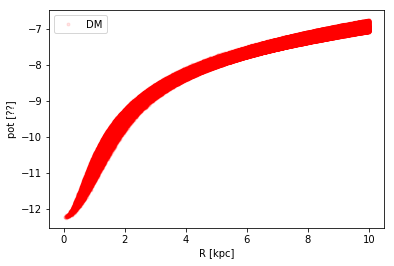

In [5]:
#plt.plot(r_stars_kpc, pot_stars, 'b.', alpha = 0.01, label = 'stars')
#plt.plot(r_gas_kpc, pot_gas, 'g.', alpha = 0.01, label = 'gas')
plt.plot(r_dm_kpc, pot_m_dm, 'r.', alpha = 0.1, label = 'DM') 
plt.legend()
plt.xlabel('R [kpc]')
plt.ylabel('pot [??]')

Text(0,0.5,'pot [??]')

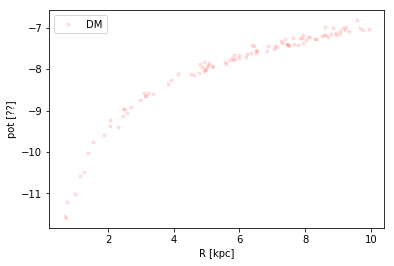

In [16]:
#dm particle (random) selection

import random
a = np.array(random.sample(list(enumerate(pot_m_dm)),100))
rand_ind = a[:,0].astype(int)
rand_pot_dm = a[:, 1]
rand_r_dm = r_dm_kpc[rand_ind]
rand_R_dm = R_dm_kpc[rand_ind]
rand_z_dm = z_dm_kpc[rand_ind]

plt.plot(rand_r_dm, rand_pot_dm, 'r.', alpha = 0.1, label = 'DM') 
plt.legend()
plt.xlabel('R [kpc]')
plt.ylabel('pot [??]')

In [17]:
### finde nen Weg um das ganze von klein r abhängig zu machen 
### finde sinnvolle Standartwerte für Initialisierungs Parameter
### eventuell nur dens ODER pot ausgeben, hängt von Fit funktion ab 
### ravel works in the way I want?


#def galpy_fitting(r, R, z, r0, v0, a_mp = 0.5, b_mp = 0.0375, n_mp = 0.6, a_nfw = 4.5, n_nfw = 0.35, \
#                  a_he = 0.6 / 8., n_he = 0.05, hr_de = 0.3333333333333333, hz_de = 0.0625, \
#                  dens_fit = True, pot_fit = False):
 

def galpy_fitting(a_mp, b_mp, n_mp, a_nfw, n_nfw, v0, r = None, R = None, z = None, r0 = None):    
    
    # stell sicher dass n_mp + n_nfw + n_he = 1, zb mit 
    #n_he = 1. - (n_mp + n_nfw)
    mp = MNpot(a = a_mp, b = b_mp, normalize = n_mp)
    nfwp = NFWpot(a = a_nfw, normalize = n_nfw)
    #hep = HEpot(a = a_he, normalize = n_he)
    pot = [mp, nfwp]#, hep]         
    pot_mod = np.zeros((len(z), len(R)))
    for ii, zii in enumerate(z):
        for jj, Rjj in enumerate(R):
            pot_mod[ii, jj] = evaluatePotentials(pot, Rjj, zii)
    return pot_mod

# FITTING

def RMS(x, r, R, z, N, pot, r0):
    a_mp, b_mp, n_mp, a_nfw, n_nfw, v0 = x[0], x[1], x[2], x[3], x[4], x[5]#, #x[6] #a_he
    ydata = pot
    ymodel = galpy_fitting(a_mp, b_mp, n_mp, a_nfw, n_nfw, v0, r, R, z, r0)
    RMS = np.sqrt(1./N*np.sum((ydata - ymodel)**2))
    #RMS = np.sum((ydata - ymodel)**2/(ydata**2))
    print(datetime.datetime.now().time())
    print(RMS)
    print(a_mp, b_mp, n_mp, a_nfw, n_nfw, v0)
    return RMS

a_mp = 0.5 
b_mp = 0.1#0.0375 
n_mp = 0.6  
a_nfw = 3 #4.5 
n_nfw = 0.35 
a_he = 0.6 / 8. 
n_he = 0.05 

v0 = 200.

pot = rand_pot_dm
r, R, z = rand_r_dm, rand_R_dm, rand_z_dm
x0 = (a_mp, b_mp, n_mp,  a_nfw , n_nfw , v0) #n_he

bounds = ((0., None), (0., None), (0., 0.999), (0., None), (0., 0.999), (0., None)) #n_he
#r, R, z, rho = R, Rbin, z, rho
#rho, R, z, vol = fitting_dens(s)

r0 = 8.
N = len(r)
# v0 muss mitgefittet werden
print(x0)

cons = ({'type': 'eq', 'fun': lambda x:  1. - (x[2] + x[4] )})

res = opt.minimize(RMS, x0 = x0, args= (r, R, z, N, pot, r0), bounds = bounds, constraints = cons)


(0.5, 0.1, 0.6, 3, 0.35, 200.0)
19:38:54.493919
60.6625879456
0.5 0.1 0.6 3.0 0.35 200.0
19:38:55.239886
60.6625879456
0.5 0.1 0.6 3.0 0.35 200.0
19:38:55.983063
60.6625879119
0.500000014901 0.1 0.6 3.0 0.35 200.0
19:38:56.729898
60.6625879071
0.5 0.100000014901 0.6 3.0 0.35 200.0
19:38:57.473301
60.6625878958
0.5 0.1 0.600000014901 3.0 0.35 200.0
19:38:58.223252
60.6625878565
0.5 0.1 0.6 3.0000000149 0.35 200.0
19:38:58.968591
60.6625871909
0.5 0.1 0.6 3.0 0.350000014901 200.0
19:38:59.715191
60.6625879456
0.5 0.1 0.6 3.0 0.35 200.000000015
19:39:00.471943
81.4819103441
2.76412916183 2.68078622818 0.00099999999546 8.97799062729 0.999 200.0
19:39:01.221337
14.6870617756
1.39674780549 1.12216535415 0.362755612822 5.36768735044 0.607047758392 200.0
19:39:01.969108
14.6870617756
1.39674780549 1.12216535415 0.362755612822 5.36768735044 0.607047758392 200.0
19:39:02.719128
14.6870616693
1.39674782039 1.12216535415 0.362755612822 5.36768735044 0.607047758392 200.0
19:39:03.460209
14.68706166

19:39:52.800692
7.7452382149
2.88896069753e-17 4.36802253758e-17 0.389308334432 7.29335636086 0.610691665568 200.0
19:39:53.550668
7.7452382149
2.88896069753e-17 4.36802253758e-17 0.389308334432 7.29335636086 0.610691665568 200.0
19:39:54.299503
7.74523821559
1.49011612227e-08 4.36802253758e-17 0.389308334432 7.29335636086 0.610691665568 200.0
19:39:55.045271
7.7452382149
2.88896069753e-17 1.49011612375e-08 0.389308334432 7.29335636086 0.610691665568 200.0
19:39:55.792232
7.74523821636
2.88896069753e-17 4.36802253758e-17 0.389308349333 7.29335636086 0.610691665568 200.0
19:39:56.532754
7.74523820796
2.88896069753e-17 4.36802253758e-17 0.389308334432 7.29335637576 0.610691665568 200.0
19:39:57.276214
7.74523816493
2.88896069753e-17 4.36802253758e-17 0.389308334432 7.29335636086 0.610691680469 200.0
19:39:58.024055
7.7452382149
2.88896069753e-17 4.36802253758e-17 0.389308334432 7.29335636086 0.610691665568 200.000000015
19:39:58.772644
7.72624303577
1.03101008343e-16 1.80418178972e-17 0.

19:40:48.339565
7.57895521655
0.0 0.508446086459 0.525610109637 9.18462499865 0.474389890363 200.0
19:40:49.071058
7.57895521655
0.0 0.508446086459 0.525610109637 9.18462499865 0.474389890363 200.0
19:40:49.799419
7.57895521844
1.49011611938e-08 0.508446086459 0.525610109637 9.18462499865 0.474389890363 200.0
19:40:50.529340
7.57895521736
0.0 0.50844610136 0.525610109637 9.18462499865 0.474389890363 200.0
19:40:51.261174
7.57895521702
0.0 0.508446086459 0.525610124538 9.18462499865 0.474389890363 200.0
19:40:51.985749
7.57895521431
0.0 0.508446086459 0.525610109637 9.18462501355 0.474389890363 200.0
19:40:52.710930
7.57895519269
0.0 0.508446086459 0.525610109637 9.18462499865 0.474389905264 200.0
19:40:53.439647
7.57895521655
0.0 0.508446086459 0.525610109637 9.18462499865 0.474389890363 200.000000015
19:40:54.169403
7.57419681269
0.0 0.529375570911 0.531907797432 9.29427866923 0.468092202568 200.0
19:40:54.895552
7.57419681269
0.0 0.529375570911 0.531907797432 9.29427866923 0.46809220

19:41:43.785015
7.52494713552
0.0 1.49011611938e-08 0.598396482872 10.7861740835 0.401603517128 200.0
19:41:44.515416
7.52494713322
0.0 0.0 0.598396497773 10.7861740835 0.401603517128 200.0
19:41:45.243180
7.52494713451
0.0 0.0 0.598396482872 10.7861740984 0.401603517128 200.0
19:41:45.974925
7.52494710953
0.0 0.0 0.598396482872 10.7861740835 0.401603532029 200.0
19:41:46.704384
7.52494713552
0.0 0.0 0.598396482872 10.7861740835 0.401603517128 200.000000015
19:41:47.433366
7.52468931479
0.0 4.72272386928e-17 0.60043743214 10.8384242914 0.39956256786 200.0
19:41:48.160486
7.52468931479
0.0 4.72272386928e-17 0.60043743214 10.8384242914 0.39956256786 200.0
19:41:48.891348
7.52468931698
1.49011611938e-08 4.72272386928e-17 0.60043743214 10.8384242914 0.39956256786 200.0
19:41:49.624370
7.52468931479
0.0 1.49011612411e-08 0.60043743214 10.8384242914 0.39956256786 200.0
19:41:50.354007
7.52468931247
0.0 4.72272386928e-17 0.600437447041 10.8384242914 0.39956256786 200.0
19:41:51.080362
7.52468

19:42:39.262234
7.52098847271
0.0046919735019 0.357515585816 0.621994780314 11.4029099051 0.378005219686 200.0
19:42:39.992281
7.52098847434
0.00469198840306 0.357515585816 0.621994780314 11.4029099051 0.378005219686 200.0
19:42:40.720421
7.52098847269
0.0046919735019 0.357515600717 0.621994780314 11.4029099051 0.378005219686 200.0
19:42:41.454175
7.52098847113
0.0046919735019 0.357515585816 0.621994795215 11.4029099051 0.378005219686 200.0
19:42:42.185675
7.52098847468
0.0046919735019 0.357515585816 0.621994780314 11.40290992 0.378005219686 200.0
19:42:42.916550
7.52098852642
0.0046919735019 0.357515585816 0.621994780314 11.4029099051 0.378005234588 200.0
19:42:43.644834
7.52098847271
0.0046919735019 0.357515585816 0.621994780314 11.4029099051 0.378005219686 200.000000015
19:42:44.375332
49.5686203028
0.0426595759012 3.58705442122 0.786949294203 15.6476836297 0.213050705797 200.0
19:42:45.105477
7.52666688925
0.00848873374184 0.680469469356 0.638490231703 11.8273872776 0.361509768297 

19:43:33.231746
7.50396083054
9.72512920995e-18 0.896242201186 0.664803523317 12.4777418575 0.335196491584 200.0
19:43:33.961920
7.50396083073
9.72512920995e-18 0.896242201186 0.664803508416 12.4777418724 0.335196491584 200.0
19:43:34.691786
7.50396083285
9.72512920995e-18 0.896242201186 0.664803508416 12.4777418575 0.335196506485 200.0
19:43:35.423355
7.50396083087
9.72512920995e-18 0.896242201186 0.664803508416 12.4777418575 0.335196491584 200.000000015
19:43:36.155409
7.50366776365
0.0 0.872547296292 0.662859698728 12.4291670966 0.337140301272 200.0
19:43:36.882509
7.50366776365
0.0 0.872547296292 0.662859698728 12.4291670966 0.337140301272 200.0
19:43:37.613994
7.50366776604
1.49011611938e-08 0.872547296292 0.662859698728 12.4291670966 0.337140301272 200.0
19:43:38.343892
7.50366776425
0.0 0.872547311193 0.662859698728 12.4291670966 0.337140301272 200.0
19:43:39.073538
7.50366776313
0.0 0.872547296292 0.662859713629 12.4291670966 0.337140301272 200.0
19:43:39.804337
7.50366776358
0

19:44:27.881176
7.49379056244
4.94940338256e-18 0.994780596298 0.704294442673 13.8933987577 0.295705557327 200.0
19:44:28.607407
7.49379049352
4.94940338256e-18 0.994780596298 0.704294442673 13.8933987428 0.295705572228 200.0
19:44:29.332551
7.49379056413
4.94940338256e-18 0.994780596298 0.704294442673 13.8933987428 0.295705557327 200.000000015
19:44:30.063007
7.49283051836
4.87273871172e-18 0.998769086615 0.703446002825 13.8739257271 0.296553997175 200.0
19:44:30.787201
7.49283051836
4.87273871172e-18 0.998769086615 0.703446002825 13.8739257271 0.296553997175 200.0
19:44:31.513708
7.49283052078
1.49011611987e-08 0.998769086615 0.703446002825 13.8739257271 0.296553997175 200.0
19:44:32.242603
7.49283051869
4.87273871172e-18 0.998769101516 0.703446002825 13.8739257271 0.296553997175 200.0
19:44:32.970275
7.49283051755
4.87273871172e-18 0.998769086615 0.703446017727 13.8739257271 0.296553997175 200.0
19:44:33.700998
7.49283051807
4.87273871172e-18 0.998769086615 0.703446002825 13.8739257

KeyboardInterrupt: 

In [ ]:
res


In [12]:
a_mp, b_mp, n_mp = res.x[0], res.x[1], res.x[2]
a_nfw , n_nfw = res.x[3]  , res.x[4]
#a_he, n_he = res.x[5],  res.x[6]

In [13]:
mp = MNpot(a = a_mp, b = b_mp, normalize = n_mp, ro = r0, vo = v0)
nfwp = NFWpot(a = a_nfw, normalize = n_nfw, ro = r0, vo = v0)
#hep = HEpot(a = a_he, normalize = 1-(n_mp+n_nfw), ro = r0, vo = v0)
    
pot = [mp,nfwp]#,hep]



In [14]:
#dens_final = galpy_fitting(a_mp, b_mp, n_mp, a_nfw , n_nfw, a_he, n_he, R= R, z= z)

/home/extmilan/anaconda3/lib/python3.6/site-packages/galpy-1.3.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/TwoPowerSphericalPotential.py:186: RuntimeWarning: divide by zero encountered in double_scalars
  return (self.a/r)**self.alpha/(1.+r/self.a)**(self.beta-self.alpha)/4./m.pi/self.a**3.

/home/extmilan/anaconda3/lib/python3.6/site-packages/numpy/core/function_base.py:128: RuntimeWarning: invalid value encountered in multiply
  y = y * step

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1176: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1176: RuntimeWarning: invalid value encountered in less
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  wa

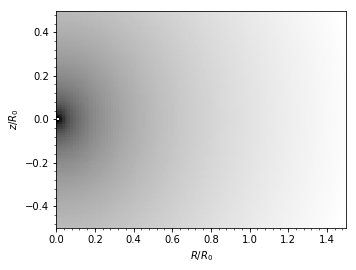

In [15]:
plotDensities(pot,nrs=101,nzs=101, log = True)